# Machine Learning 0 - Introduction

In this lab, we will introduce the classification problem that we will be working on for the last three labs. The objectives of the lab are:

* Examine the dataset and prepare the basic pipeline that will be used in the next lab.
* Make sure that we use a correct methodology for comparing the algorithms
* Get used to working with the [scikit-learn](https://scikit-learn.org/stable/) library.

## Introduction to the dataset

The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset has been collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. It consists of 60.000 32x32 colour images, split in 10 classes: 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'.

*Reference: Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.* PDF available at https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf

For the purpose of the INFO-H-501 laboratories, we will use a subset of those images by only taking 3 different classes: 'airplane', 'bird' and 'horse'.

[Click here to download](https://my.pcloud.com/publink/show?code=XZJUCPkZqiVxqtn8CXRB7D78YKt88RJvzWyk) the modified dataset. Extract the ZIP file and put the CIFAR10 folder in the same directory as the notebook.

The images are 32x32 8-bit **RGB**, and from these we extracted **Histogram of Gradient** vectors (16 orientations x 16 blocks = 256 values in HoG vector).

The following code pre-loads all of this data (make sure that you have the [lab_tools.py](https://github.com/odebeir/info-h-500-501/blob/master/LABS1/lab_tools.py) file in the same directory as the notebook, if you didn't clone the repository):

In [6]:
# imports
from lab_tools import CIFAR10, get_hog_image
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import itertools
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.linear_model import RidgeClassifier

In [3]:
dataset = CIFAR10('data/CIFAR10/')

Pre-loading training data
Pre-loading test data


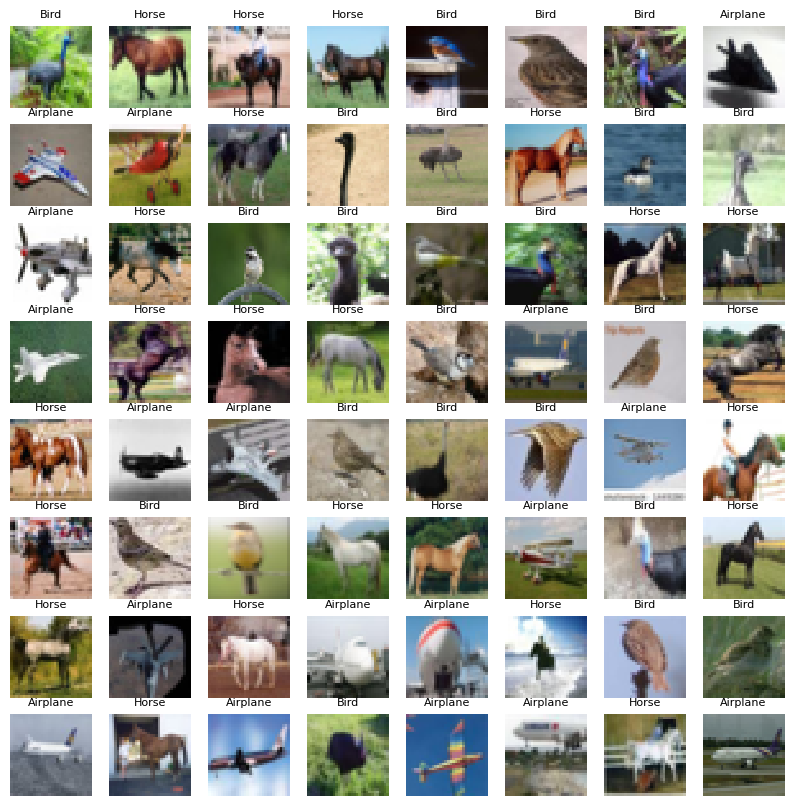

In [ ]:
%matplotlib inline
# visualize images
plt.figure(figsize=(10,10))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(dataset.train['images'][i].reshape((32,32,3)), interpolation='none')
    plt.title(dataset.labels[dataset.train['labels'][i]], fontsize=8)
    plt.axis('off')
plt.show()

We can also have a look at some HoG images (Histogram of Oriented Gradients is a feature descriptor that captures the distribution (histogram) of edge directions (gradients) in localized portions (“cells”) of an image):
1. Resize a sample image to 128×128 → 4×4 cells of 32×32 pixels each.
2. Compute HOG with 16 orientation bins per cell, 1 × 1 cell blocks (so each cell’s histogram is independent).
   > Gradient computation allows to determing Gradient Magnitude and Gradient Direction for every pixel. Then we divide by the bins orientations to determine the histogram. The feature vector is composed of the 16 bins components. Every cell will have a feature vector and we combine all cells by group of 4 of them to have final concatenated feature vector of 256 dimensions. HoG gives a concatenated representation of the image.
4. Reshape the resulting HOG array to (4, 4, 16).
5. Visualize using your get_hog_image function, drawing a little line for each orientation weighted by bin magnitude.

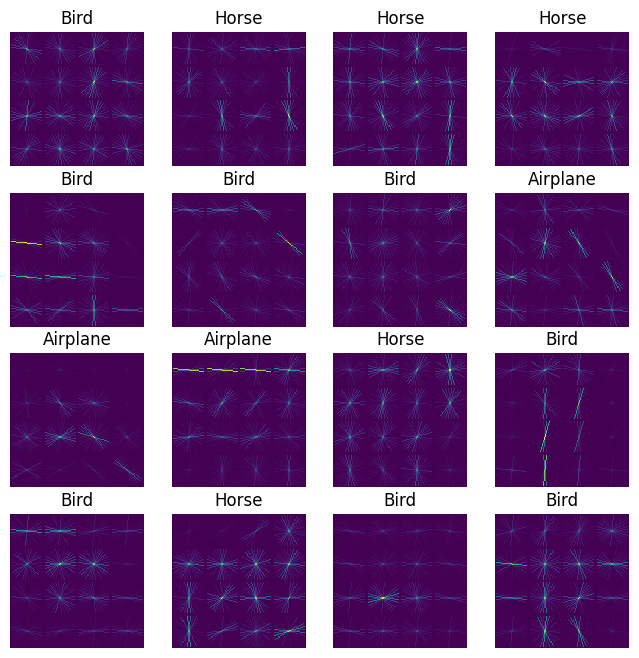

In [11]:
# visualize hog
plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    hog = dataset.train['hog'][i].reshape((4,4,16))
    plt.imshow(get_hog_image(hog, 128), interpolation='none')
    plt.title(dataset.labels[dataset.train['labels'][i]])
    plt.axis('off')
plt.show()

Note that this is an "image" representation of the HoG, but that the actual data that we will be working on is a size 256 vector for each image. Our **feature space** has therefore 256 dimensions. 

## Exploring the dataset

The *dataset* object gives you access to different attributes:

* *dataset.path* contains the path to the CIFAR10 folder.
* *dataset.labels* contains the name of the three classes
* *dataset.train* and *dataset.test* are dictionaries containing three numpy arrays each:
    * *images* contains the RGB images
    * *hog* contains the HoG vectors
    * *labels* contains the label for each image

In [12]:
# path where the data is stored
print(f"Dataset path: {dataset.path}")

# names of the three classes we’re using
print("Class labels:", dataset.labels)

# contents of the training dictionary
print("Keys in dataset.train:", list(dataset.train.keys()))

# shape of the HoG feature array (n_samples × 256)
print("HoG feature matrix shape:", dataset.train['hog'].shape)

Dataset path: data/CIFAR10/
Class labels: ['Airplane', 'Bird', 'Horse']
Keys in dataset.train: ['images', 'hog', 'labels']
HoG feature matrix shape: (15000, 256)


### Quick questions:

The dataset has already been split into a training set (dataset.train) and a test set (dataset.test).

* How many images are in the training set ?
* How many images are in the test set ?
* What is the class distribution of the dataset ?

In [ ]:
# Number of images
n_train = len(dataset.train['images'])
n_test = len(dataset.test['images'])

print(f"Training images: {n_train}")
print(f"Test images: {n_test}")

Training images: 15000
Test images: 3000


In [15]:
# show the first 10 training labels (as indices and class names)
first_indices = dataset.train['labels'][:10]
print("First 10 training label indices:", first_indices)
print("First 10 training class names:  ",
      [dataset.labels[i] for i in first_indices])

# count samples per class in both train and test splits
print("Training set:")
for c in range(3):
    print(dataset.labels[c], (dataset.train['labels']==c).sum())

print("Test set:")
for c in range(3):
    print(dataset.labels[c], (dataset.test['labels']==c).sum())

# class distribution of the dataset is balanced

First 10 training label indices: [1 2 2 2 1 1 1 0 0 0]
First 10 training class names:   ['Bird', 'Horse', 'Horse', 'Horse', 'Bird', 'Bird', 'Bird', 'Airplane', 'Airplane', 'Airplane']
Training set:
Airplane 5000
Bird 5000
Horse 5000
Test set:
Airplane 1000
Bird 1000
Horse 1000


### Descriptive data analysis

Look at the HoG data from the training set. What are the characteristics of the dataset ? Do you think that some pre-processing may be required to help with the different algorithms ?

First HoG vector shape: (256,)


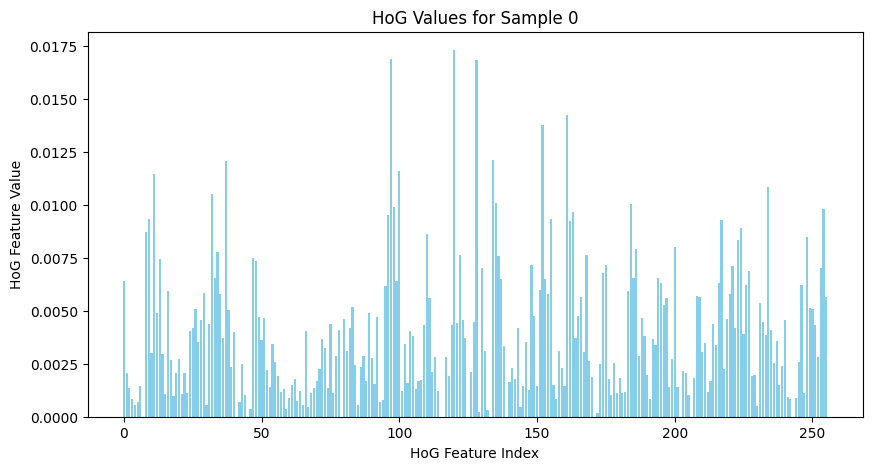

In [19]:
# inspect the shape of the first HoG vector
hog0 = dataset.train['hog'][0]
print("First HoG vector shape:", hog0.shape)

# plot the HoG values for that sample
plt.figure(figsize=(10, 5))
plt.bar(
    range(hog0.size), 
    hog0, 
    color='skyblue',
    alpha=1
)
plt.title("HoG Values for Sample 0")
plt.xlabel("HoG Feature Index")
plt.ylabel("HoG Feature Value")
plt.show()

# every value is positive, all values are quite small and close to 0
# optimal scenario for most of the classifiers
# data is not centered around the origin which is needed for some classifiers

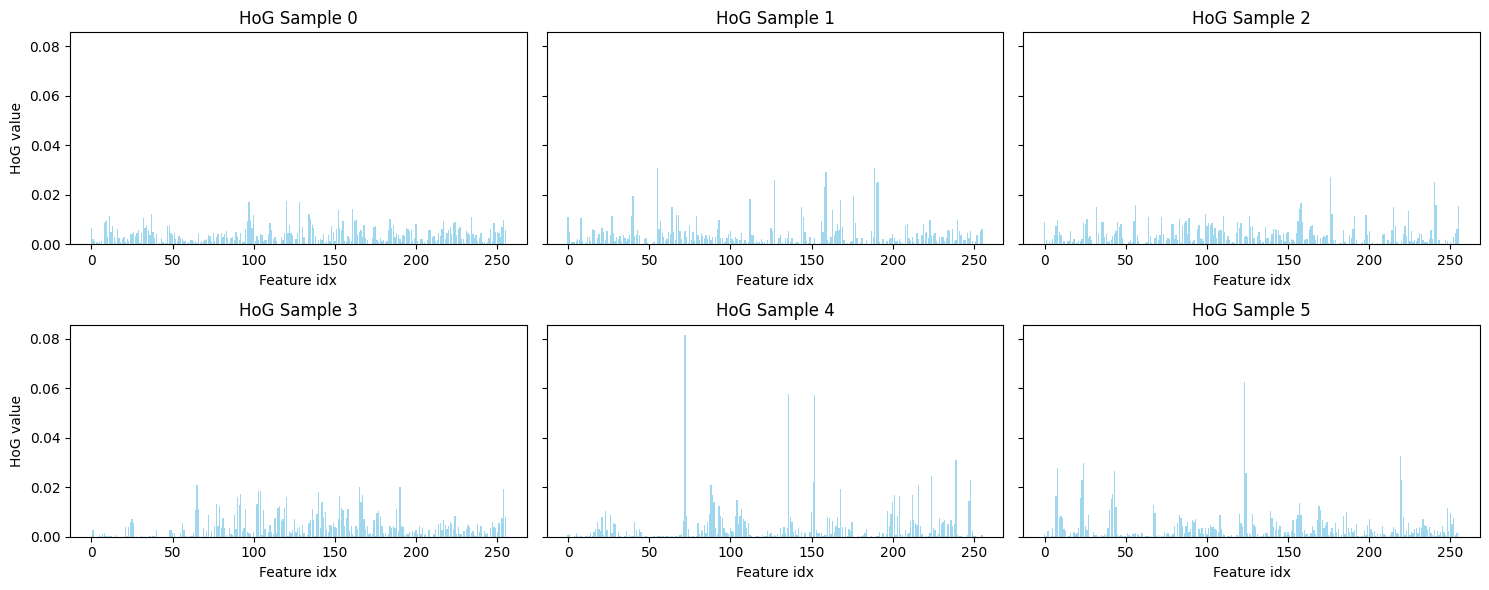

In [20]:
n_plots = 6
n_cols  = 3
n_rows  = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6), sharey=True)

for i in range(n_plots):
    ax = axes.flat[i]
    hog_vec = dataset.train['hog'][i]
    
    ax.bar(
        range(hog_vec.size),
        hog_vec,
        color='skyblue',
        alpha=0.8
    )
    ax.set_title(f"HoG Sample {i}")
    ax.set_xlabel("Feature idx")
    if i % n_cols == 0:
        ax.set_ylabel("HoG value")

# Turn off any unused subplots
for j in range(n_plots, n_rows * n_cols):
    axes.flat[j].axis('off')

plt.tight_layout()
plt.show()

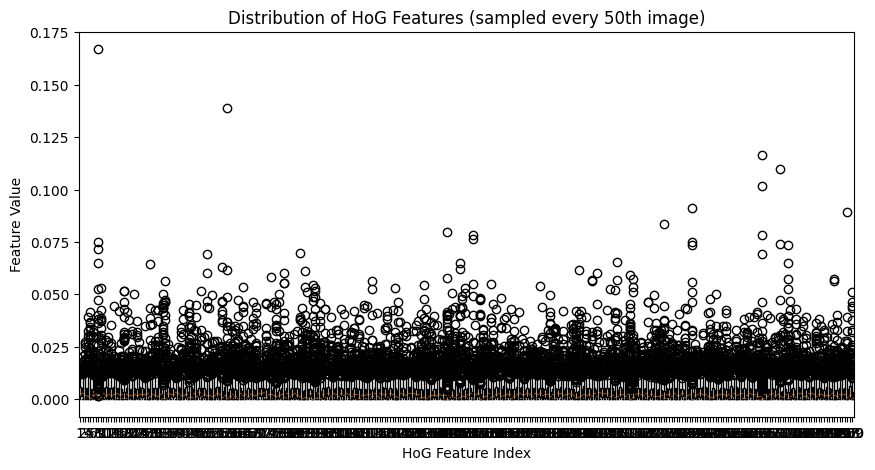

In [19]:
# sample every 50th HoG vector to avoid overplotting
plt.figure(figsize=(10,5))
plt.xlabel("HoG Feature Index")
plt.ylabel("Feature Value")
plt.title("Distribution of HoG Features (sampled every 50th image)")
plt.boxplot(dataset.train['hog'][::50].T)
plt.show()

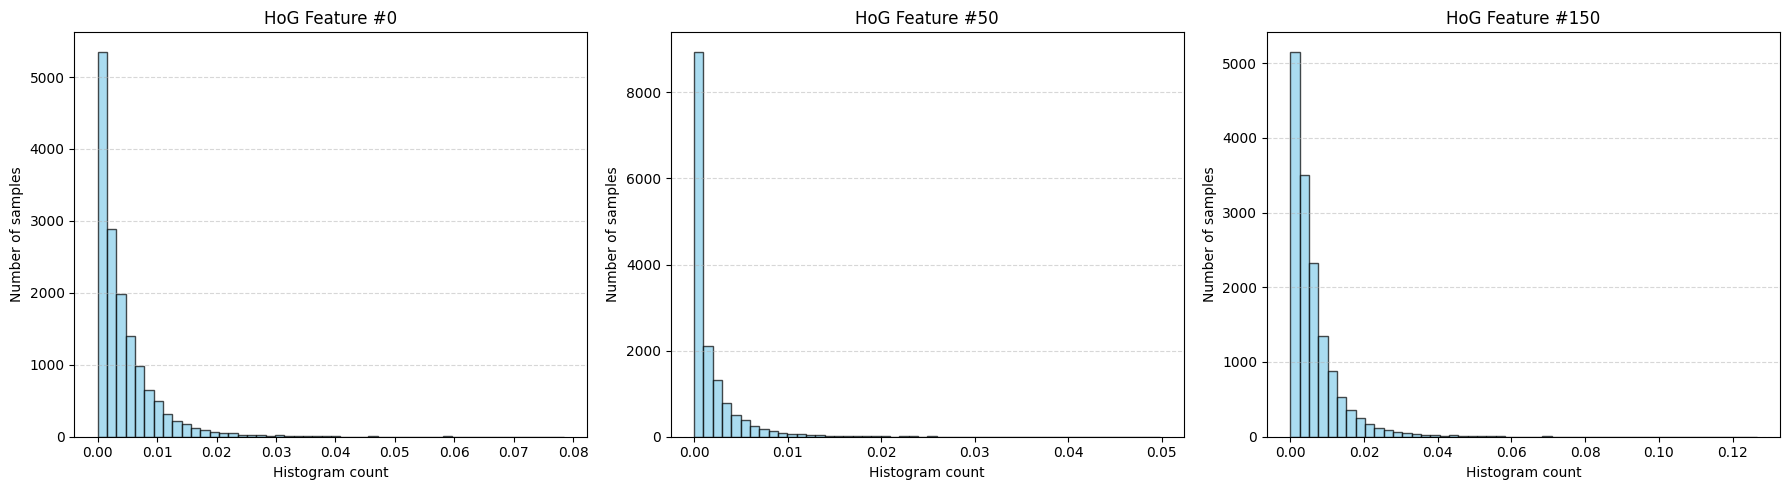

In [31]:
hog_data = dataset.train['hog']
feature_indices = [0, 50, 150]
n_bins = 50

fig, axes = plt.subplots(1, len(feature_indices), figsize=(18, 5))

for ax, idx in zip(axes, feature_indices):
    values = hog_data[:, idx]
    ax.hist(
        values,
        bins=n_bins,
        color='skyblue',
        edgecolor='black',
        alpha=0.7
    )
    ax.set_title(f"HoG Feature #{idx}")
    ax.set_xlabel("Histogram count")
    ax.set_ylabel("Number of samples")
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# lots of values close to 0

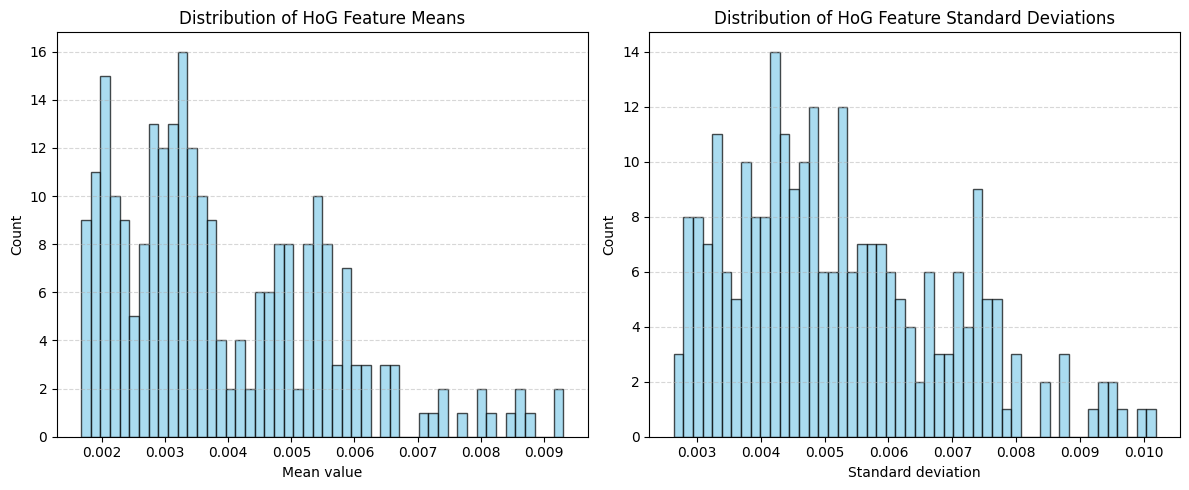

In [32]:
# compute per‐feature means and standard deviations
feature_means = np.mean(hog_data, axis=0)
feature_stds  = np.std(hog_data,  axis=0)

# plot distributions
plt.figure(figsize=(12, 5))

# distribution of feature means
ax1 = plt.subplot(1, 2, 1)
ax1.hist(feature_means, 
         bins=50, 
         color='skyblue',
         edgecolor='black',
         alpha=0.7
)
ax1.set_title("Distribution of HoG Feature Means")
ax1.set_xlabel("Mean value")
ax1.set_ylabel("Count")
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# distribution of feature standard deviations
ax2 = plt.subplot(1, 2, 2)
ax2.hist(feature_stds, 
         bins=50, 
         color='skyblue',
         edgecolor='black',
         alpha=0.7
)
ax2.set_title("Distribution of HoG Feature Standard Deviations")
ax2.set_xlabel("Standard deviation")
ax2.set_ylabel("Count")
ax2.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

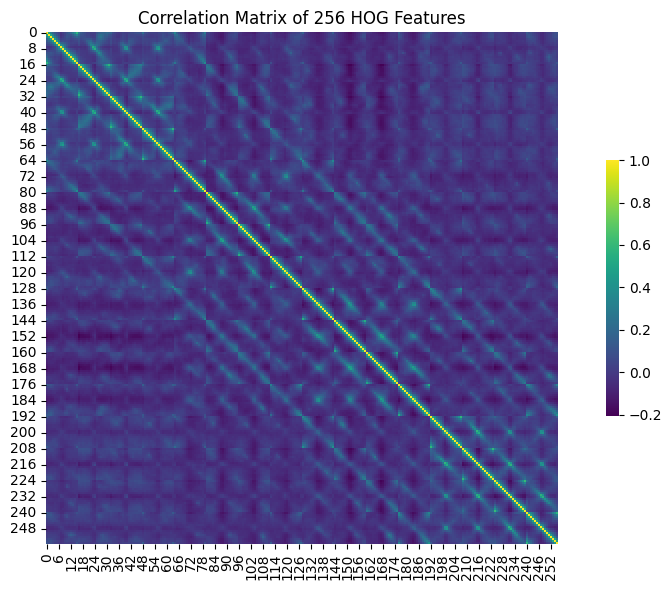

In [ ]:
# compute the 256×256 feature–feature correlation matrix
corr = np.corrcoef(hog_data.T)

# plot it
plt.figure(figsize=(10, 6))
sns.heatmap(
    corr,
    cmap="viridis",
    square=True,
    cbar_kws={
        "shrink": 0.5,
        "aspect": 20
    }
)
plt.title("Correlation Matrix of 256 HOG Features")
plt.tight_layout()
plt.show()

In [ ]:
X = dataset.train['hog']
corr = np.corrcoef(X, rowvar=False)
print(corr.shape)

# find all feature pairs with high absolute correlation
high_corr = np.argwhere(np.abs(corr) > 0.6)
# drop self‐pairs and duplicate i<j
to_drop = set()
for i, j in high_corr:
    if i < j:
        to_drop.add(j)   # arbitrarily drop the later feature in each highly‐corr pair

keep_idx = [i for i in range(256) if i not in to_drop]
X_reduced = X[:, keep_idx]
print("Dropped", len(to_drop), "features—new dim:", X_reduced.shape[1])

(256, 256)
Dropped 2 features—new dim: 254


183 components explain ≥95% of variance


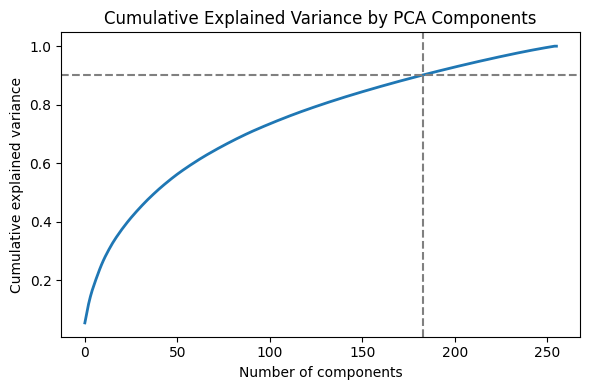

Resulting shape: (15000, 183)


In [4]:
# standardize so PCA isn’t dominated by large‐scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(dataset.train['hog'])
X_test_scaled = scaler.transform(dataset.test['hog'])

# fit PCA and examine cumulative explained variance
pca = PCA().fit(X_train_scaled)
cumvar = np.cumsum(pca.explained_variance_ratio_)
# find how many components to retain, e.g. 90% variance
n_components_90 = np.searchsorted(cumvar, 0.90) + 1  

print(f"{n_components_90} components explain ≥95% of variance")

plt.figure(figsize=(6,4))
plt.plot(cumvar, lw=2)
plt.axhline(0.9, color="gray", ls="--")
plt.axvline(n_components_90, color="gray", ls="--")
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.tight_layout()
plt.show()

# project down
pca = PCA(n_components=n_components_90, whiten=True, random_state=0)
X_pca = pca.fit_transform(X_train_scaled)
print("Resulting shape:", X_pca.shape)

**What are the characteristics of the HoG dataset?**  
- We have **15 000 samples** and **324 dimensions**  
  – computed as 9 orientation-bins × (2×2 cells per block) × 18 overlapping blocks = 324  
- **Feature means** lie between ~0.065 and 0.21 (overall mean ∼0.13), so features are not zero-centered  
- **Feature stds** range from ~0.07 to 0.12, indicating some bins barely vary while others fluctuate more  
- The **full 324×324 correlation matrix** shows strong, structured redundancy (banded blocks of high correlation)  
- **PCA** reveals you need only **≈ 93** components to capture 90 % of the variance  

**Pre-processing recommendations:**  
1. **Standardize** each feature to zero-mean and unit variance  
2. **Decorrelate** via PCA/whitening or **cluster** highly correlated bins and average or prune them

## Introduction to scikit-learn

[Scikit-learn](https://scikit-learn.org/stable/) is a very well documented machine learning library in Python. It contains many algorithms for [classification](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning), and makes the whole process of building a machine learning pipeline relatively straightforward. There are many examples in the documentation, as well as relatively complete theoretical explanations, so I really encourage you to take the time to read it if some things are not clear.

Let's make a very simple example. We are going to use the [Ridge Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier), which is a very basic linear model.

In [38]:
from sklearn.linear_model import RidgeClassifier

To use a classifier with scikit-image, we generally have three steps:

* Create an instance of the class of the classifier (here: RidgeClassifier). The constructor will generally contain many arguments that can be modified, and that are explained in the documentation. There will also generally be default values for all of them, so in this simple example we will just use those:

In [39]:
clf = RidgeClassifier()

* Use the *fit* method with, as arguments, the training data (in our case, the HoG vectors) and the corresponding labels. This will start the main training algorithm, trying to fit the parameters of the classifier with the training data:

In [40]:
clf.fit(dataset.train['hog'], dataset.train['labels'])

RidgeClassifier()

* Use the *predict* method to get the prediction of the classifier on the data given as argument. In this case, we get the predictions on the data that was just used for training. **What kind of performance will that give us?**

In [41]:
pred = clf.predict(dataset.train['hog'])
print(pred.shape)

(15000,)


We can then evaluate those predictions. Scikit-learn provides many different [metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) for evaluating the performances of a classifier. The most simple of those is the accuracy, which is simply the number of correct predictions divided by the total number of predictions:

In [ ]:
score = accuracy_score(dataset.train['labels'], pred)
print(f"Accuracy: {score:.4f}")

# it’s just as easy to compute this "by hand"
T = (pred==dataset.train['labels']).sum()
print(f"Correct predictions: {T}, total: {len(pred)}, accuracy: {T/len(pred)}")

Accuracy: 0.7357
Correct predictions: 11035, total: 15000, accuracy: 0.7356666666666667


In a multiclass problem, it's often also very useful to look at the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix), which gives us more information on which classes are often mistaken for each other:

In [ ]:
# confusion matrix
cm = confusion_matrix(dataset.train['labels'], pred)
print(cm)

[[3812  740  448]
 [ 742 3236 1022]
 [ 337  676 3987]]


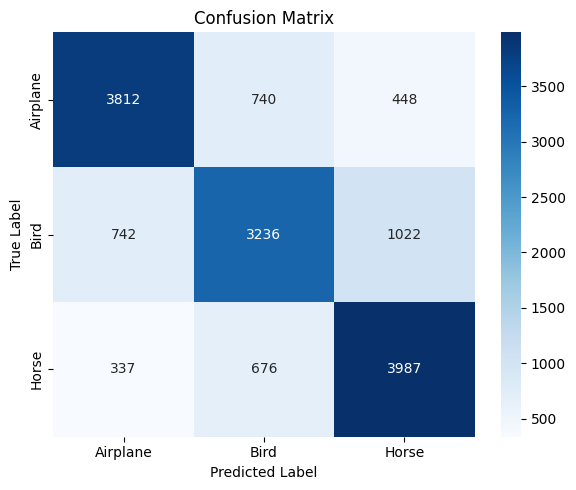

In [56]:
# plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=dataset.labels,
    yticklabels=dataset.labels
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

Note that the rows represent the **true labels** and the columns the **predicted labels**. So this mean that, in this case, out of the 5000 images of class 0 ("Airplane"), 3812 were correctly classified, 740 were classified as "Bird" and 448 as "Horse").

### Quick question

* Modify the code to estimate the **predictive** performance of the algorithm (without using the test set).

In [ ]:
%%time

# data
X, y = dataset.train['hog'], dataset.train['labels']
clf = RidgeClassifier()

# Descriptive performance (on full training set)
clf.fit(X, y)
y_train_pred = clf.predict(X)
train_acc = accuracy_score(y, y_train_pred)
train_cm = confusion_matrix(y, y_train_pred)

print("--- Descriptive performance ---")
print(f"Training accuracy: {train_acc:.4f}")
print("Training confusion matrix:")
print(train_cm)

# Predictive performance (10‑fold cross‑validation)
cv_scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
y_cv_pred = cross_val_predict(clf, X, y, cv=5)
cv_acc = accuracy_score(y, y_cv_pred)
cv_cm = confusion_matrix(y, y_cv_pred)

print("\n--- Predictive performance (5‑fold CV) ---")
print("Fold accuracies: ", np.round(cv_scores, 4))
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")
print(f"Overall CV accuracy: {cv_acc:.4f}")
print("CV confusion matrix:")
print(cv_cm)

--- Descriptive performance ---
Training accuracy: 0.7357
Training confusion matrix:
[[3812  740  448]
 [ 742 3236 1022]
 [ 337  676 3987]]

--- Predictive performance (5‑fold CV) ---
Fold accuracies:  [0.725  0.7333 0.724  0.7217 0.7263]
Mean CV accuracy: 0.7261
Overall CV accuracy: 0.7261
CV confusion matrix:
[[3788  756  456]
 [ 785 3158 1057]
 [ 362  693 3945]]


In [7]:
%%time

# data
X_train, y_train = dataset.train['hog'], dataset.train['labels']
X_test, y_test  = dataset.test['hog'],  dataset.test['labels']
# standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(dataset.train['hog'])
X_test_scaled = scaler.transform(dataset.test['hog'])

clf = RidgeClassifier()

# descriptive performance (on full training set)
clf.fit(X_train_scaled, y_train)
y_train_pred = clf.predict(X_train_scaled)
train_acc = accuracy_score(y_train, y_train_pred)
train_cm  = confusion_matrix(y_train, y_train_pred)

print("--- Descriptive performance ---")
print(f"Training accuracy: {train_acc:.4f}")
print("Training confusion matrix:")
print(train_cm)

# predictive performance (5‑fold cross‑validation)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
cv_scores = cross_val_score(
    clf, 
    X_train_scaled, 
    y_train, 
    cv=cv, 
    scoring='accuracy', 
    n_jobs=-1
)
y_cv_pred = cross_val_predict(clf, X_train_scaled, y_train, cv=5)
cv_acc = accuracy_score(y_train, y_cv_pred)
cv_cm = confusion_matrix(y_train, y_cv_pred)

print("\n--- Predictive performance (5‑fold CV) ---")
print("Fold accuracies: ", np.round(cv_scores, 4))
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")
print(f"Overall CV accuracy: {cv_acc:.4f}")
print("CV confusion matrix:")
print(cv_cm)

--- Descriptive performance ---
Training accuracy: 0.7596
Training confusion matrix:
[[3866  679  455]
 [ 641 3481  878]
 [ 256  697 4047]]

--- Predictive performance (5‑fold CV) ---
Fold accuracies:  [0.7403 0.7387 0.7413 0.7547 0.7473]
Mean CV accuracy: 0.7445
Overall CV accuracy: 0.7412
CV confusion matrix:
[[3781  738  481]
 [ 670 3381  949]
 [ 283  761 3956]]
CPU times: total: 1 s
Wall time: 4.86 s


## How can we find the "best" algorithm?

What we have shown above served to illustrate how scikit-learn classifiers work, but we now have to build a valid machine learning pipeline to compare the different algorithms that we will use in the next labs.

As we have said earlier, we have already split the dataset into a "training" and a "test" set. It is clear that the final evaluation should take place on the test set.

But in addition to comparing the algorithms between each other, we also have to find the best "hyper-parameters" for each algorithm. For example, in our RidgeClassifier example, there is a regularization parameters, *alpha*, which by default was set to 1.0. Can we improve the performance of the algorithm by modifying this parameter ?

### Side-note: parameter vs hyper-parameter

In general, when talking about machine learning models, **parameters** are what the algorithm learns with the data (if we are for instance learning a linear regression y = ax+b, the "parameters" would be a and b), while **hyper-parameters** are modifiers to the model or to the pipeline (for instance, if we are generalizing to a polynomial regression, the degree of the polynome would be an hyper-parameter).

### Cross-validation

The most common way of finding the best hyper-parameters of a classifier is to use [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

* Using the [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) method from scikit-learn, find the best *alpha* hyper-parameter for the RidgeClassifier: 

α= 0.0010, mean CV accuracy = 0.7415
α= 0.0032, mean CV accuracy = 0.7413
α= 0.0100, mean CV accuracy = 0.7420
α= 0.0316, mean CV accuracy = 0.7441
α= 0.1000, mean CV accuracy = 0.7443
α= 0.3162, mean CV accuracy = 0.7395
α= 1.0000, mean CV accuracy = 0.7261
α= 3.1623, mean CV accuracy = 0.7069
α=10.0000, mean CV accuracy = 0.6911
α=31.6228, mean CV accuracy = 0.6843
α=100.0000, mean CV accuracy = 0.6815
α=316.2278, mean CV accuracy = 0.6797
α=1000.0000, mean CV accuracy = 0.6795

Best α: 0.1
Best mean CV accuracy: 0.7442666666666666


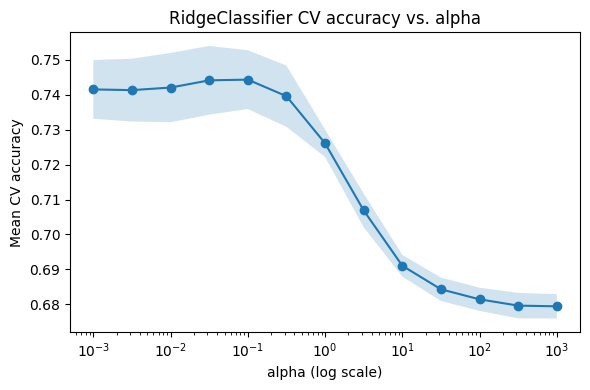

In [12]:
# training data
X, y = dataset.train['hog'], dataset.train['labels']

# candidate alphas (from 1e‑3 to 1e3 in log‐space)
alphas = np.logspace(-3, 3, 13)

best_alpha = None
best_score = -np.inf
mean_scores = []
std_scores  = []

for alpha in alphas:
    # instantiate with this α
    clf = RidgeClassifier(alpha=alpha)
    # 5‑fold CV with accuracy scoring
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    mean_score = scores.mean()
    mean_scores.append(scores.mean())
    std_scores.append(scores.std())
    print(f"α={alpha:>7.4f}, mean CV accuracy = {mean_score:.4f}")

    if mean_score > best_score:
        best_score = mean_score
        best_alpha = alpha

print("\nBest α:", best_alpha)
print("Best mean CV accuracy:", best_score)

# Plot CV accuracy vs alpha
plt.figure(figsize=(6,4))
plt.semilogx(alphas, mean_scores, marker='o')
plt.fill_between(alphas,
                 np.array(mean_scores)-np.array(std_scores),
                 np.array(mean_scores)+np.array(std_scores),
                 alpha=0.2)
plt.xlabel("alpha (log scale)")
plt.ylabel("Mean CV accuracy")
plt.title("RidgeClassifier CV accuracy vs. alpha")
plt.tight_layout()
plt.show()

### Comparing algorithms

Once you have found the best hyper-parameters for an algorithm, you can re-train the classifier on the whole training set, and finally use the test set to get a "final performance". 

* How can you then decide which of the classifiers is best ?
* How can you decide if the different between two classifiers is significant ?

Try to compare the best RidgeClassifier with the original. Is it significantly better?

In [60]:
from scipy.stats import chi2

# split out your test data
X_train, y_train = dataset.train['hog'], dataset.train['labels']
X_test, y_test = dataset.test['hog'], dataset.test['labels']

# train both models on the *entire* training set
clf_def = RidgeClassifier(alpha=1.0).fit(X_train, y_train)
clf_tuned = RidgeClassifier(alpha=0.1).fit(X_train, y_train)

# get test‐set predictions
pred_def = clf_def.predict(X_test)
pred_tuned = clf_tuned.predict(X_test)

# compute accuracies
acc_def = accuracy_score(y_test, pred_def)
acc_tuned = accuracy_score(y_test, pred_tuned)
print(f"default α=1.0 test accuracy: {acc_def:.4f}")
print(f" tuned  α=0.1 test accuracy: {acc_tuned:.4f}")

# build the McNemar contingency
b = np.sum((pred_def == y_test) & (pred_tuned != y_test))  # def right, tuned wrong
c = np.sum((pred_def != y_test) & (pred_tuned == y_test))  # def wrong, tuned right

# McNemar’s χ² with continuity correction
chi2_stat = (abs(b - c) - 1)**2 / (b + c)
p_value = 1 - chi2.cdf(chi2_stat, df=1)
print(f"McNemar = {chi2_stat:.3f}, p‐value = {p_value:.3f}")

default α=1.0 test accuracy: 0.7290
 tuned  α=0.1 test accuracy: 0.7400
McNemar χ² = 4.995, p‐value = 0.025


### Test Set Performance

- **Default Ridge (α=1.0):** 72.90%
- **Tuned Ridge (α=0.1):** 74.00%

### McNemar’s Test

- **χ²** = 4.995, **p** = 0.025 (< 0.05)
- Reject the null hypothesis of equal performance

The tuned **RidgeClassifier (α=0.1)** yields a modest but statistically significant improvement over the default model on the held-out test set.